# Model Consolidation

### Libraries

In [22]:
import numpy as np
import matplotlib.pyplot as plt   
%matplotlib inline
from music21 import *
from IPython.display import Audio
from intervaltree import Interval,IntervalTree
import pandas as pd
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import sklearn.model_selection as model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


mn_data = np.load('musicnet.npz','rb',allow_pickle=True)

### Import csv features which were extracted from earlier Data PreProcessing notebook

In [5]:
#Get metadata
#metadata=pd.read_csv('../data/musicnet_metadata.csv')

# Get consolidated saved csvs of WAV Spectral features only
#train_wav = pd.read_csv('../data/df_train_wav_consolidated.csv',index_col=0)
#test_wav = pd.read_csv('../data/df_test_wav_finc.csv',index_col=0)

#Get midi features only
#midi_features = pd.read_csv('../data/midi_features.csv',index_col=0)

metadata=pd.read_csv('cvs_data/musicnet_metadata.csv')

# Get consolidated saved csvs of WAV Spectral features only
train_wav = pd.read_csv('cvs_data/df_train_wav_consolidated.csv',index_col=0)
test_wav = pd.read_csv('cvs_data/df_test_wav_finc.csv',index_col=0)

#Get midi features only
midi_features = pd.read_csv('cvs_data/midi_features.csv',index_col=0)

### Import Wav Data for Spectral Features only

In [6]:
#Create X and y for Wav Data only

#Make a copy of the metadata
meta_data_copy = metadata.copy(deep=True)
meta_data_copy.reset_index(inplace=True)

#Rename column name
meta_data_copy = meta_data_copy.rename(columns = {'id':'filename'})

#Merge Metadata and Wav Data Only
merged_train_data_w = pd.merge(train_wav , meta_data_copy , on="filename")
merged_train_data_w = merged_train_data_w.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index"], axis=1)

merged_test_data_w = pd.merge(test_wav , meta_data_copy , on="filename")
merged_test_data_w = merged_test_data_w.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index"], axis=1)

#Checked that unique ensembles in test are a subset of train
#Get list of unique ensembles
ens_list = merged_train_data_w['ensemble'].unique()

#Map list of unique ensemble names to integer
mapping = {item:i for i, item in enumerate(ens_list)}
merged_train_data_w["ensemble"] = merged_train_data_w["ensemble"].apply(lambda x: mapping[x])
merged_test_data_w["ensemble"] = merged_test_data_w["ensemble"].apply(lambda x: mapping[x])

#This is the original train test split given in kaggle. 
#The code is selecting only the ensemble for the y and letting the rest of the features be in X

X_original_train = merged_train_data_w.iloc[:,np.r_[:167,168]]
X_original_test = merged_test_data_w.iloc[:,np.r_[:167,168]]

y_original_train = merged_train_data_w.iloc[:,167:168]
y_original_test = merged_test_data_w.iloc[:,167:168]

#Concatenate the training and test data
x_frames = [X_original_train,X_original_test]
X_wav = pd.concat(x_frames , ignore_index=True)

y_frames = [y_original_train,y_original_test]
y_wav = pd.concat(y_frames , ignore_index=True)

#Find the index position of viola quintet and drop it since there is only one ensemble of that type
index_violaquintet_wav_only = y_wav[ y_wav['ensemble'] == 3 ].index
y_wav.drop(index_violaquintet_wav_only , inplace=True)
X_wav.drop(index_violaquintet_wav_only , inplace=True)

#This is the train test split for Spectral Wav Data only
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

C:\Users\nojed\anaconda3\lib\site-packages\pandas\core\frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Print list of ensembles for reference

In [7]:
#print ensemble list
ens_list

array(['Piano Quintet', 'Solo Piano', 'Piano Trio', 'Viola Quintet',
       'String Quartet', 'Clarinet Quintet',
       'Pairs Clarinet-Horn-Bassoon', 'Wind Quintet', 'Accompanied Cello',
       'Accompanied Clarinet', 'Wind and Strings Octet', 'String Sextet',
       'Piano Quartet', 'Horn Piano Trio', 'Solo Violin', 'Solo Flute',
       'Solo Cello', 'Violin and Harpsichord',
       'Clarinet-Cello-Piano Trio', 'Accompanied Violin', 'Wind Octet'],
      dtype=object)

### Import MIDI Features for Engineered Features from Granular Data

In [8]:
#Create X and y for Granular MIDI Data Attributes only

#Make a copy of the midi features
midi_features_copy = midi_features.copy(deep=True)
midi_features_copy.reset_index(inplace=True)

#Rename column name in both the copy and the original
midi_features_copy = midi_features_copy.rename(columns = {'file_name':'filename'})
midi_features = midi_features.rename(columns = {'file_name':'filename'})


#Merge Metadata and MIDI Data only

#For original midi
merged_midi_data = pd.merge(midi_features , meta_data_copy , on="filename")
merged_midi_data = merged_midi_data.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index"], axis=1)

#For midi copy
merged_midi_data_copy = pd.merge(midi_features_copy , meta_data_copy , on="filename")
merged_midi_data_copy = merged_midi_data_copy.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index_x"], axis=1)

#Map list of unique ensemble names to integer

#For original midi
merged_midi_data["ensemble"] = merged_midi_data["ensemble"].apply(lambda x: mapping[x])

#For midi copy
merged_midi_data_copy["ensemble"] = merged_midi_data_copy["ensemble"].apply(lambda x: mapping[x])

#To select data for train and test for midi based on the same splits done for wav based on multiple conditions you can use &:
#Removes file name as a feature and also removes viola quintet
midi_train = merged_midi_data.loc[merged_midi_data['filename'].isin(filenames_in_train)]
X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

midi_test = merged_midi_data.loc[merged_midi_data['filename'].isin(filenames_in_test)]
X_test_m = midi_test.iloc[:,np.r_[1:10,11]]
y_test_m = midi_test.iloc[:,np.r_[10]]

### Create Merged Dataset comprising Engineered Features from MIDI Data and Spectral Features from Wav Data

In [9]:
# Create Dataset with MIDI and WAV Spectral Data

#Drop duplicate columns
merged_midi_data_copy.drop(['seconds','index_y'],axis=1,inplace=True) 

#Find the index position of viola quintet and drop it since there is only one ensemble of that type
index_violaquintet_midi_only = merged_midi_data_copy[ merged_midi_data_copy['ensemble'] == 3 ].index
merged_midi_data_copy.drop(index_violaquintet_midi_only , inplace=True)

#Merge Midi and Wav Data 
merged_data_c = pd.merge(X_wav, merged_midi_data_copy , on="filename")

#To select data for train and test for midi based on the same splits done for wav based on multiple conditions you can use &:
#Removes file name as a feature and also removes viola quintet
comb_train = merged_data_c.loc[merged_data_c['filename'].isin(filenames_in_train)]
X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]

comb_test = merged_data_c.loc[merged_data_c['filename'].isin(filenames_in_test)]
X_test_c = comb_test.iloc[:,np.r_[0,2:177]]
y_test_c = comb_test.iloc[:,np.r_[177]]

In [10]:
print('Shape of Wav Data :')
print( X_train_w.shape, y_train_w.shape , X_test_w.shape , y_test_w.shape)

Shape of Wav Data :
(263, 167) (263, 1) (66, 167) (66, 1)


In [11]:
print('Shape of MIDI Data :')
print( X_train_m.shape, y_train_m.shape , X_test_m.shape , y_test_m.shape)

Shape of MIDI Data :
(263, 10) (263, 1) (66, 10) (66, 1)


In [12]:
print('Shape of Combined Wav and MIDI Data :')
print( X_train_c.shape, y_train_c.shape , X_test_c.shape , y_test_c.shape)

Shape of Combined Wav and MIDI Data :
(263, 176) (263, 1) (66, 176) (66, 1)


# Models

## 1. Logistic Regression

### 1.1 Spectral (WAV) Data Only

#### 1.1.1 Baseline model

In [16]:
lr = LogisticRegression(C = 0.5, solver='liblinear', multi_class='auto')
lr.fit(np.array(X_train_w), np.array(y_train_w))
scores = cross_val_score(estimator = lr, X=X_train_w, y=y_train_w, cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

Linear regression
CV Scores:  [0.88679245 0.88679245 0.86792453 0.90384615 0.94230769]
CV Average and standard deviation:  0.8975326560232221 +/- 0.02510780470472868


#### 1.1.2 PCA components

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

[0.8496704647266673, 0.9432045674275258, 0.9657437073371651, 0.9740154026128449, 0.980814681037099, 0.9842105572644043, 0.9869234364301775, 0.9895492330696728]


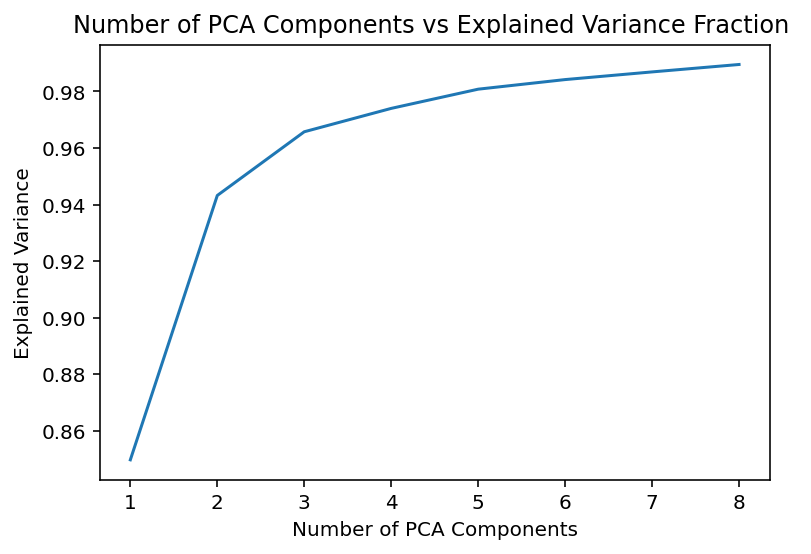

Linear regression
CV Scores:  [0.67924528 0.69811321 0.66037736 0.71153846 0.69230769]
CV Average and standard deviation:  0.6883164005805515 +/- 0.017401420621599144


C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

In [26]:
#all possible values of principal components can go up to the number of features
all_possible_k = range(1,len(X_train_w.columns))

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca = PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    
    #Logistic Regression Model with PCA
    lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
    lr.fit(train_pca,y_train_w)

plt.plot(all_possible_k[0:8], all_possible_k_variance[0:8])
print(all_possible_k_variance[0:8])

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()

pca = PCA(n_components = 5)
pca.fit(X_train_w)
X_train_pca = pca.transform(X_train_w)

lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
lr.fit(X_train_pca,y_train_w)
scores = cross_val_score(estimator = lr, X=X_train_pca, y=y_train_w, cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))
      

### 1.2 MIDI Data Only 

#### 1.2.1 Baseline model

In [17]:
lr = LogisticRegression(C = 0.5, solver='liblinear', multi_class='auto')
lr.fit(np.array(X_train_m), np.array(y_train_m))
scores = cross_val_score(estimator = lr, X=X_train_m, y=y_train_m, cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

Linear regression
CV Scores:  [0.69811321 0.75471698 0.67924528 0.65384615 0.76923077]
CV Average and standard deviation:  0.7110304789550072 +/- 0.044142917620219664


#### 1.2.2 PCA components

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

[0.847246925156634, 0.9999994828649594, 0.9999999950423858, 0.9999999979326264, 0.9999999995373896, 0.9999999998110075, 0.9999999999006715, 0.9999999999631857]


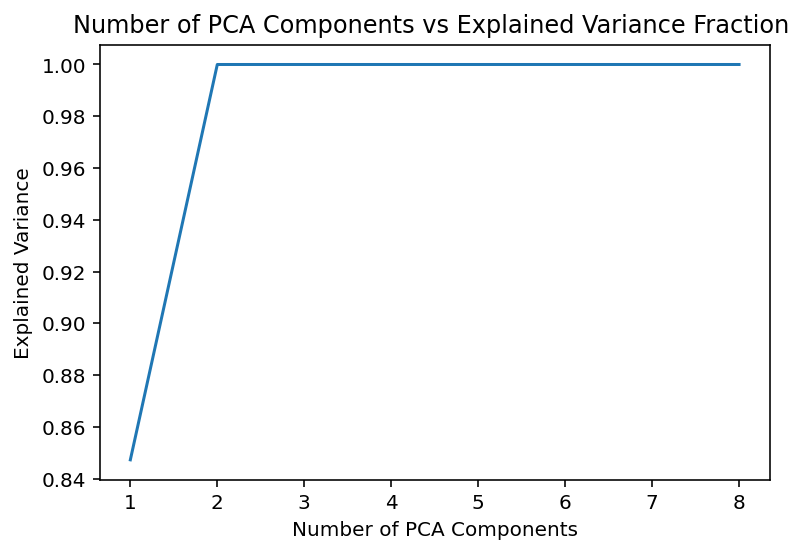

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

Linear regression
CV Scores:  [0.47169811 0.47169811 0.16981132 0.48076923 0.48076923]
CV Average and standard deviation:  0.4149492017416546 +/- 0.1226360559071233


In [28]:
#all possible values of principal components can go up to the number of features
all_possible_k = range(1,len(X_train_m.columns))

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca = PCA(n_components = i)
    pca.fit(X_train_m)
    train_pca = pca.transform(X_train_m)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    
    #Logistic Regression Model with PCA
    lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
    lr.fit(train_pca,y_train_w)

plt.plot(all_possible_k[0:8], all_possible_k_variance[0:8])
print(all_possible_k_variance[0:8])

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()

pca = PCA(n_components = 5)
pca.fit(X_train_m)
X_train_pca = pca.transform(X_train_m)

lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
lr.fit(X_train_pca,y_train_w)
scores = cross_val_score(estimator = lr, X=X_train_pca, y=y_train_w, cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))


### 1.3 Combined Data (WAV & MIDI) 

#### 1.3.1 Baseline model

In [18]:
lr = LogisticRegression(C = 0.5, solver='liblinear', multi_class='auto')
lr.fit(np.array(X_train_c), np.array(y_train_c))
scores = cross_val_score(estimator = lr, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

Linear regression
CV Scores:  [0.81132075 0.86792453 0.90566038 0.82692308 0.90384615]
CV Average and standard deviation:  0.863134978229318 +/- 0.038690476180831046


#### 1.3.2 PCA components

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

[0.8472467564714535, 0.9999993006005323, 0.9999998191050802, 0.9999999250480672, 0.9999999510448121, 0.9999999628415001, 0.9999999703478009, 0.9999999753281146]


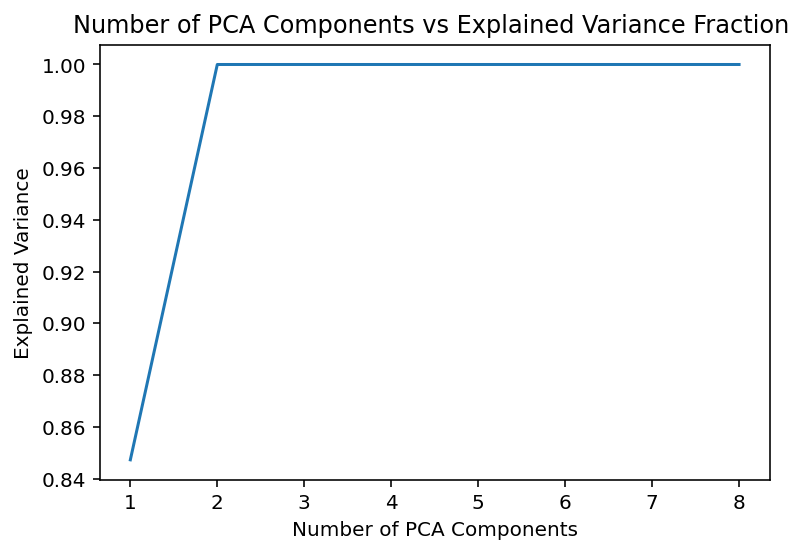

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

Linear regression
CV Scores:  [0.47169811 0.43396226 0.45283019 0.48076923 0.46153846]
CV Average and standard deviation:  0.4601596516690857 +/- 0.016123374972447535


In [30]:
#all possible values of principal components can go up to the number of features
all_possible_k = range(1,len(X_train_c.columns))

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca = PCA(n_components = i)
    pca.fit(X_train_c)
    train_pca = pca.transform(X_train_c)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    
    #Logistic Regression Model with PCA
    lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
    lr.fit(train_pca,y_train_w)

plt.plot(all_possible_k[0:8], all_possible_k_variance[0:8])
print(all_possible_k_variance[0:8])

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()

pca = PCA(n_components = 5)
pca.fit(X_train_c)
X_train_pca = pca.transform(X_train_c)

lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
lr.fit(X_train_pca,y_train_c)
scores = cross_val_score(estimator = lr, X=X_train_pca, y=y_train_w, cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))


---------------------------------------------------------------------------------------------------------------------------

## Data import
---------------------------------------------------------------------------------------------------------------------------

In [31]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]


C:\Users\nojed\anaconda3\lib\site-packages\pandas\core\frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## 2. Naive Bayes

### 2.1 Spectral (WAV) Data Only

#### 2.1.1 Baseline model

#### 2.1.2 PCA components

### 2.2 MIDI Data Only

#### 2.2.1 Baseline model

#### 2.2.2 PCA components

### 2.3 Combined Data (WAV & MIDI)

#### 2.3.1 Baseline model

#### 2.3.2 PCA components

---------------------------------------------------------------------------------------------------------------------------

## Data import
---------------------------------------------------------------------------------------------------------------------------

In [ ]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]


## 3. Decision Tree

### 3.1 Spectral (WAV) Data Only

#### 3.1.1 Baseline model

#### 3.1.2 PCA components

### 3.2 MIDI Data Only

#### 3.2.1 Baseline model

#### 3.1.2 PCA components

### 3.3 Combined Data (WAV & MIDI)

#### 3.3.1 Baseline model

#### 3.3.2 PCA components

---------------------------------------------------------------------------------------------------------------------------

## Data import
---------------------------------------------------------------------------------------------------------------------------

In [ ]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]


## 4. Decision Tree

### 4.1 Spectral (WAV) Data Only

#### 4.1.1 Baseline model

#### 4.1.2 PCA components

### 4.2 MIDI Data Only

#### 4.2.1 Baseline model

#### 4.2.2 PCA components

### 4.3 Combined Data (WAV & MIDI)

#### 4.3.1 Baseline model

#### 4.3.2 PCA components

---------------------------------------------------------------------------------------------------------------------------

## Data import
---------------------------------------------------------------------------------------------------------------------------

In [ ]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]


## 5. Random Forest

### 5.1 Spectral (WAV) Data Only

#### 5.1.1 Baseline model

#### 5.1.2 Sampling (SMOTE), no hyperparameter tuning

#### 5.1.3 Sampling (SMOTE), hyperparameter tuning

### 5.2 MIDI Data Only

#### 5.2.1 Baseline model

#### 5.2.2 Sampling (SMOTE), no hyperparameter tuning

#### 5.2.3 Sampling (SMOTE), hyperparameter tuning

### 5.3 Combined Data (WAV & MIDI)

#### 5.3.1 Baseline model

#### 5.3.2 Sampling (SMOTE), no hyperparameter tuning

#### 5.3.2 Sampling (SMOTE), hyperparameter tuning

---------------------------------------------------------------------------------------------------------------------------

## Data import
---------------------------------------------------------------------------------------------------------------------------

In [ ]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]


## 6. SVM

### 6.1 Spectral (WAV) Data Only

#### 6.1.1 Baseline model

#### 5.1.2 Hyperparameter tuning

#### 6.1.3 Hyperparameter tuning, PCA

#### 6.1.4 Hyperparameter tuning, PCA, SMOTE, Min Max Scaler

#### 6.1.5 Hyperparameter tuning, PCA, SMOTE, Standard Scaler

### 6.2 MIDI Data Only

#### 6.2.1 Baseline model

#### 6.2.2 Hyperparameter tuning

#### 6.2.3 SMOTE, PCA

### 6.3 Combined Data (WAV & MIDI)

#### 6.3.1 Baseline model

#### 6.3.2 Hyperparameter tuning

#### 6.3.2 Hyperparameter tuning, PCA

---------------------------------------------------------------------------------------------------------------------------

## Data import
---------------------------------------------------------------------------------------------------------------------------

In [ ]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]

## 7. Neural Network

### 7.1 Spectral (WAV) Data Only

#### 7.1.1 Baseline model

#### 7.1.2 PCA components

### 7.2 MIDI Data Only

#### 7.2.1 Baseline model

#### 7.2.2 PCA components

### 7.3 Combined Data (WAV & MIDI)

#### 7.3.1 Baseline model

#### 7.3.2 PCA components